#### 1. Sources
[Face Mask First dataset](https://www.kaggle.com/datasets/andrewmvd/face-mask-detection)

[Face Mask Detection 12K Images Dataset](https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset)

[Haarcascade Models](https://www.kaggle.com/datasets/lalitharajesh/haarcascades)

[Caffe Face Detection Model](https://www.kaggle.com/datasets/sambitmukherjee/caffe-face-detector-opencv-pretrained-model)

**Objective:**

Identiying if a person is wearing facemask or not

In [2]:
## Importing libraries
import pandas as pd
import numpy as np
import cv2
import os
import glob
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential, models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns

2023-04-25 23:23:23.202698: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-25 23:23:23.218384: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-25 23:23:23.302948: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-25 23:23:23.303523: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 23:23:23.790992: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

### Getting the directories, Path and Data

In [3]:
path = "Face Mask Dataset/"

In [4]:
dataset = {
    "image_path": [],
    "mask_status": [],
    "where": []
}

for where in os.listdir(path):
    for status in os.listdir(path+"/"+where):
        for image in glob.glob(path+where+"/"+status+"/"+"*.png"):
            dataset["image_path"].append(image)
            dataset["mask_status"].append(status)
            dataset["where"].append(where)
            
dataset = pd.DataFrame(dataset)
dataset.head()

,image_path,mask_status,where
0,Face Mask Dataset/Train/WithMask/Augmented_313...,WithMask,Train
1,Face Mask Dataset/Train/WithMask/1128.png,WithMask,Train
2,Face Mask Dataset/Train/WithMask/Augmented_191...,WithMask,Train
3,Face Mask Dataset/Train/WithMask/Augmented_531...,WithMask,Train
4,Face Mask Dataset/Train/WithMask/Augmented_505...,WithMask,Train


### Face Detection using HAAR Cascade Algorithm

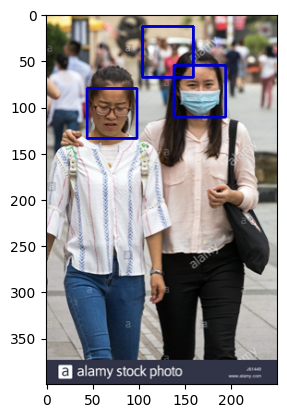

In [6]:
## Choosing a random image to detect the face in the image
face_model = cv2.CascadeClassifier('haarcasacdes/haarcascade_frontalface_default.xml')

## Choosing the image from the directory
img = cv2.imread("Medical Faces/images/maksssksksss352.png")

## Converting the image to grayscale to apply haarcascade algorithm
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

## Returns the x, y, w, h co-ordinates as numpy arrays for all the detected faces
detected_face = face_model.detectMultiScale(img)

## Converting from grayscale to colored image
output_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

## Drawing rectangle box around the faces in the image
for (x, y, w, h) in detected_face:
    cv2.rectangle(output_img, (x,y), (x+w, y+h), (0, 0, 200), 2)
    
## Displaying the image
# plt.figure(figsize = (15, 15))
plt.imshow(output_img)

### Drawbacks:
We can observe that Default face detection Haar Cascading that we choose doesnt do a good job in identifying the faces. (Will replace this with other algorithms)

### Try Another Algorithm To Detect Faces

In [67]:
cvNet = cv2.dnn.readNetFromCaffe(prototxt="model/deploy.prototxt",
                                            caffeModel="model/res10_300x300_ssd_iter_140000_fp16.caffemodel")

def cvDnnDetectFaces(image, min_confidence=0.5, display = True):
    
    image_height, image_width, _ = image.shape

    output_image = image.copy()
    
    out_images = []

    preprocessed_image = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(300, 300),
                                               mean=(104.0, 117.0, 123.0), swapRB=False, crop=False)

    cvNet.setInput(preprocessed_image)

    results = cvNet.forward()    

        
    for face in results[0][0]:
        
        face_confidence = face[2]
        
        if face_confidence > min_confidence:

            bbox = face[3:]

            x1 = int(bbox[0] * image_width)
            y1 = int(bbox[1] * image_height)
            x2 = int(bbox[2] * image_width)
            y2 = int(bbox[3] * image_height)

            out_im = output_image[y1:y2, x1:x2].copy()
            out_im = cv2.resize(out_im, (150, 150))
            # normalize the output
            out_im = out_im / 255
            
            out_images.append(out_im)
            
            
            cv2.rectangle(output_image, pt1=(x1, y1), pt2=(x2, y2), color=(0, 255, 0), thickness=image_width//200)


    if display:


        plt.figure(figsize=[20,20])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output");plt.axis('off');
        
    else:
        return out_images, results 

(150, 150, 3)
(150, 150, 3)


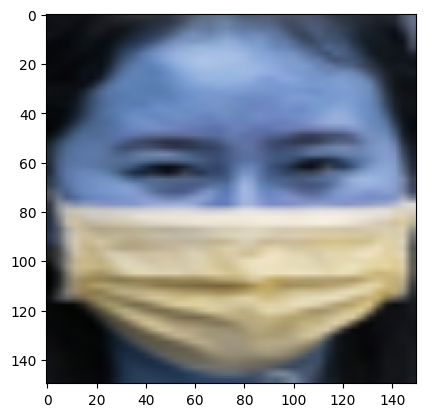

In [68]:
image =  cv2.imread("Medical Faces/images/maksssksksss352.png")
out, r = cvDnnDetectFaces(image, display=False)
print(out[0].shape)
print(out[1].shape)
plt.imshow(out[1])

### Visualization

With Mask: 5909
Without Mask: 5883


<Axes: xlabel='mask_status', ylabel='count'>

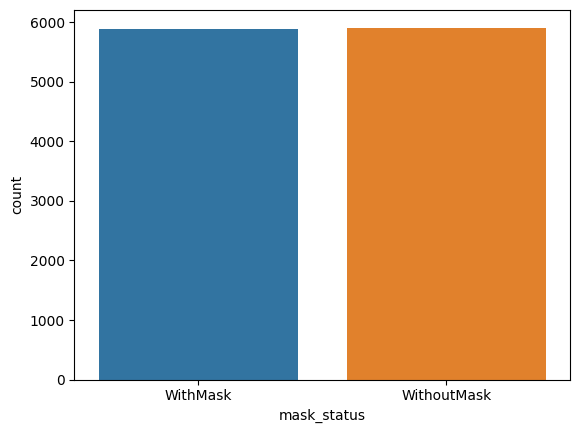

In [9]:
## Checking for total number of images in the dataset
print(f"With Mask:", dataset.value_counts("mask_status")[0])
print(f"Without Mask:", dataset.value_counts("mask_status")[1])

## Plotting the numbers
sns.countplot(x = dataset["mask_status"])

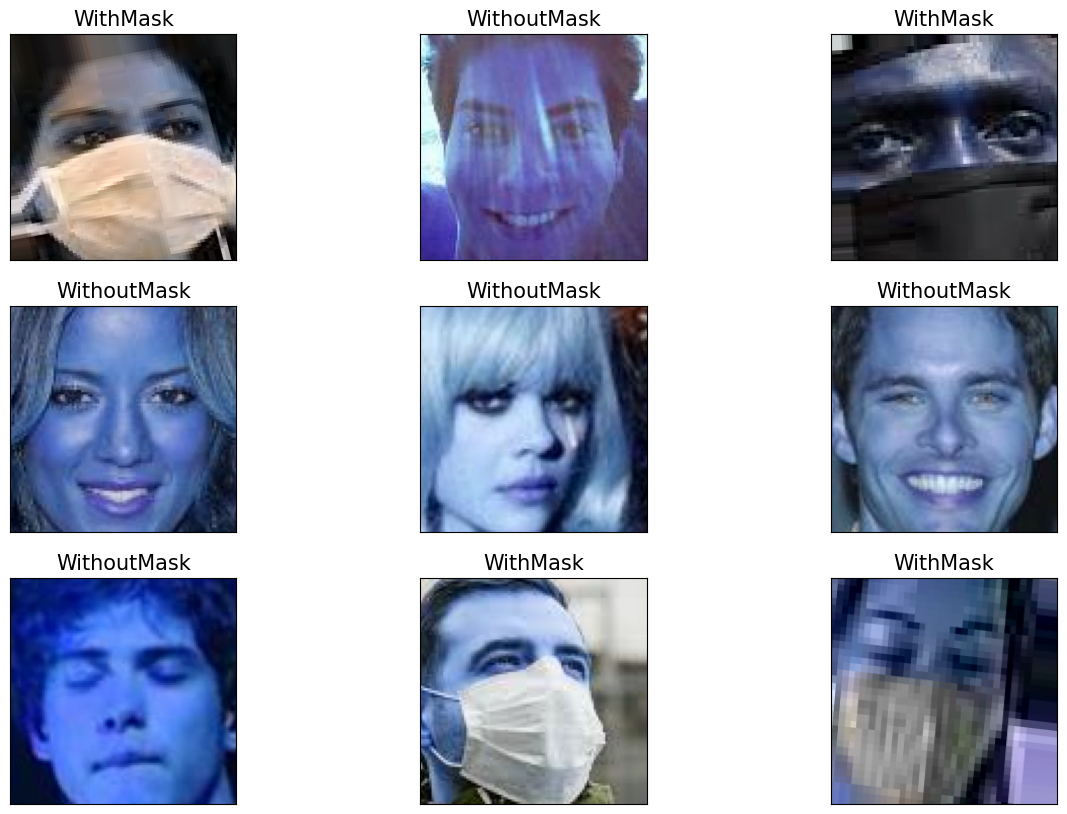

In [10]:
plt.figure(figsize = (15, 10))

for i in range(9):
    random = np.random.randint(1, len(dataset))
    plt.subplot(3, 3, i+1)
    plt.imshow(cv2.imread(dataset.loc[random,"image_path"]))
    plt.title(dataset.loc[random,"mask_status"], size = 15)
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [11]:
## Splitting train test and Validation Dataset
train_df = dataset[dataset["where"] == "Train"]
test_df = dataset[dataset["where"] == "Test"]
valid_df = dataset[dataset["where"] == "Validation"]

print(train_df.head(10))

## Shuffling the dataset 
train_df = train_df.sample(frac = 1)
test_df = test_df.sample(frac = 1)
valid_df = valid_df.sample(frac = 1)

print("\n After Shuffling \n")
print(train_df.head(10))

                                          image_path mask_status  where
0  Face Mask Dataset/Train/WithMask/Augmented_313...    WithMask  Train
1          Face Mask Dataset/Train/WithMask/1128.png    WithMask  Train
2  Face Mask Dataset/Train/WithMask/Augmented_191...    WithMask  Train
3  Face Mask Dataset/Train/WithMask/Augmented_531...    WithMask  Train
4  Face Mask Dataset/Train/WithMask/Augmented_505...    WithMask  Train
5           Face Mask Dataset/Train/WithMask/500.png    WithMask  Train
6          Face Mask Dataset/Train/WithMask/1316.png    WithMask  Train
7  Face Mask Dataset/Train/WithMask/Augmented_16_...    WithMask  Train
8          Face Mask Dataset/Train/WithMask/1489.png    WithMask  Train
9  Face Mask Dataset/Train/WithMask/Augmented_614...    WithMask  Train

 After Shuffling 

                                             image_path  mask_status  where
6720       Face Mask Dataset/Train/WithoutMask/2502.png  WithoutMask  Train
3219  Face Mask Dataset/Train/WithMa

### Visualising the distribution of train test and validation set

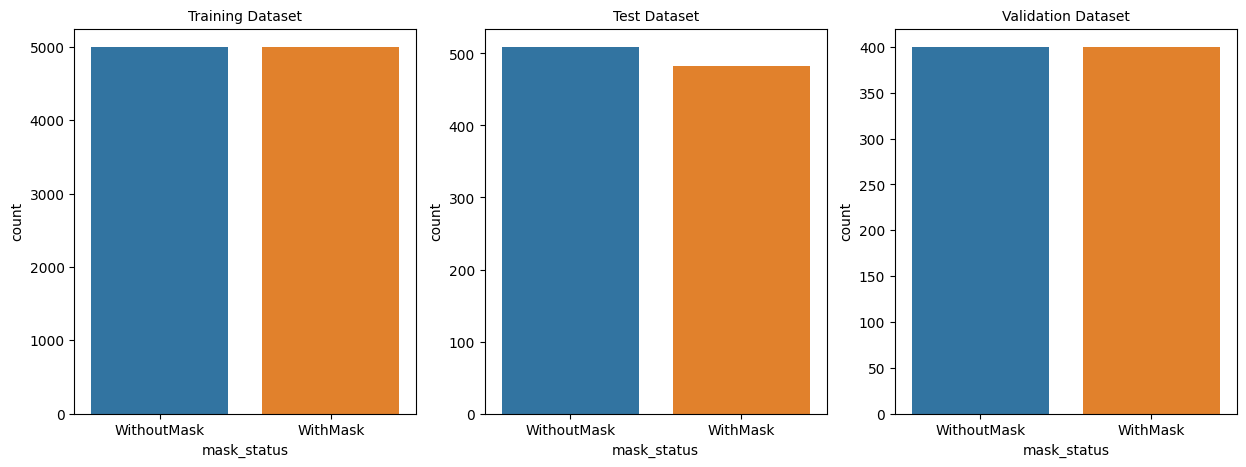

In [12]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
sns.countplot(x = train_df["mask_status"])
plt.title("Training Dataset", size = 10)

plt.subplot(1, 3, 2)
sns.countplot(x = test_df["mask_status"])
plt.title("Test Dataset", size = 10)

plt.subplot(1, 3, 3)
sns.countplot(x = valid_df["mask_status"])
plt.title("Validation Dataset", size = 10)

plt.show()

In [13]:
train_df = train_df.reset_index().drop("index", axis = 1)
train_df.head()

,image_path,mask_status,where
0,Face Mask Dataset/Train/WithoutMask/2502.png,WithoutMask,Train
1,Face Mask Dataset/Train/WithMask/Augmented_56_...,WithMask,Train
2,Face Mask Dataset/Train/WithoutMask/1048.png,WithoutMask,Train
3,Face Mask Dataset/Train/WithMask/Augmented_326...,WithMask,Train
4,Face Mask Dataset/Train/WithMask/89.png,WithMask,Train


In [14]:
## Reading all the image into a list and changing the size of the image to (150,150)
data = []
image_size = 150

for i in range(len(train_df)):
    ## Converting the image into grayscale
    img_array = cv2.imread(train_df["image_path"][i], cv2.IMREAD_GRAYSCALE)

    ## Resizing the array
    new_image_array = cv2.resize(img_array, (image_size, image_size))

    ##Encoding the image with the label
    if train_df["mask_status"][i] == "WithMask":
        data.append([new_image_array, 1])
    else:
        data.append([new_image_array, 0])

In [15]:
data[1]

[array([[35, 37, 38, ..., 75, 50, 34],
        [32, 32, 33, ..., 66, 48, 33],
        [32, 32, 32, ..., 60, 44, 33],
        ...,
        [42, 40, 36, ..., 42, 42, 42],
        [41, 38, 35, ..., 43, 43, 42],
        [41, 37, 35, ..., 43, 43, 43]], dtype=uint8),
 1]

In [16]:
data[0][0].shape

(150, 150)

In [17]:
## Shuffling the data to make sure everything is not in order
np.random.shuffle(data)

In [ ]:
## Looking at the training samples

fig, ax = plt.subplots(2, 3, figsize=(10, 10))

for row in range(2):
    for col in range(3):
        image_index = row*100+col
        
        ax[row, col].axis("off")
        ax[row,col].imshow(data[image_index][0], cmap = "gray")
    
        if data[image_index][1] == 0:
            ax[row, col].set_title("Without Mask")
        else:
            ax[row, col].set_title("With Mask")
            
plt.show()

### Preparing data to be loaded into the Model

In [66]:
X = []
y = []

## Seperating X and y
for image in data:
    X.append(image[0])
    y.append(image[1])
    
## Converting X and y to numpy array as Tensorflow accepts only numpy arrays
X = np.array(X)
y = np.array(y)

## Print The Image
print(X[100].shape)

(150, 150)


In [41]:
### Normalizing the data
X = X/255

### Train Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Building the model

In [47]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = "relu"))
model.add(Conv2D(64, (3, 3), activation = "relu"))
model.add(MaxPool2D(pool_size=(3, 3)))
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))
# model.summary()

In [48]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [49]:
# X_train = X_train.reshape(-1, 32, 150, 150)
## Reshaping training set to match Conc2D
X_train = X_train.reshape(len(X_train), X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(len(X_val), X_val.shape[1], X_val.shape[2], 1)

history = model.fit(X_train, y_train, epochs=5, batch_size = 32)

Epoch 1/5
250/250 [==============================] - 289s 1s/step - loss: 0.2142 - accuracy: 0.9111
Epoch 2/5
250/250 [==============================] - 298s 1s/step - loss: 0.0629 - accuracy: 0.9785
Epoch 3/5
250/250 [==============================] - 341s 1s/step - loss: 0.0395 - accuracy: 0.9866
Epoch 4/5
250/250 [==============================] - 337s 1s/step - loss: 0.0256 - accuracy: 0.9911
Epoch 5/5
250/250 [==============================] - 345s 1s/step - loss: 0.0313 - accuracy: 0.9879


In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (32, 148, 148, 64)        640       
                                                                 
 conv2d_3 (Conv2D)           (32, 146, 146, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 48, 48, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (32, 147456)              0         
                                                                 
 dense_2 (Dense)             (32, 128)                 18874496  
                                                                 
 dense_3 (Dense)             (32, 1)                   129       
                                                      

In [51]:
model.evaluate(X_val, y_val)

63/63 [==============================] - 19s 299ms/step - loss: 0.0934 - accuracy: 0.9780


[0.09336084127426147, 0.9779999852180481]

In [52]:
prediction = model.predict(X_val)

63/63 [==============================] - 19s 296ms/step


In [53]:
predicts = []
for p in prediction:
    if p[0] > 0.6:
        predicts.append(1)
    else:
        predicts.append(0)

In [54]:
print(classification_report(y_val, predicts))
print(confusion_matrix(y_val, predicts))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       997
           1       0.97      0.99      0.98      1003

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000

[[965  32]
 [  8 995]]


In [72]:
image =  cv2.imread("Medical Faces/images/maksssksksss352.png")
out, r = cvDnnDetectFaces(image, display=False)

f = out[1]
print(f.shape)
print(X_val[0].shape)
# model.predict(X_val[0])

(150, 150, 3)
(150, 150, 1)


In [ ]:
X_train = X_train.reshape(len(X_train), X_train.shape[1], X_train.shape[2], 1)
X_train[2].shape